# Building and Optimizing an Emulator

Let's build an emulator for a quantum scattering problem with an optical potential! We will choose neutron scattering on the $^{40}$ Ca nucleus as our test problem. In particular, we want to build an emulator that can predict the differential elastic scattering cross section for this reaction, at a given energy as quickly and accurately as possible. 

We have the following Hamiltonian as the radial part of the scattering equation:

\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0,
\end{equation}

where a system with reduced mass $\mu$ interacts through a potential $V(r,\alpha)=U(r,\alpha)/2\mu$ with parameters $\alpha$, $\ell$ is the angular momentum quantum number, and $p$ is the asymptotic linear momentum. In the code implementation we re-scale the equation to work in dimensionless units $s=rp$. Our reduced basis expansion of $n$ basis can be written as:

\begin{equation}
   \phi(r) \approx \phi_0(r) + \sum_k^n a_k\phi_k(r)
\end{equation}


The goal of this tutorial is to demonstrate how to build such an emulator with ROSE, and then choose the optimal emulator configuration to accomplish this. For a video and other notebook resources on ROSE [check this link](https://indico.cern.ch/event/1223721/contributions/5394829/). The full derivation of the involved equations, both for the high fidelity and the reduced basis counter part, will be presented in an upcoming publication and linked here.


Let's get to it then. First, we'll import all the modules we need and set up the scattering system.

In [1]:
# pip install nuclear-rose (if you don't have it already)
# pip install nuclear-rose==0.9.4a0 
# import ROSE to construct the emulator
import rose

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc
import pickle

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime

plt.rcParams.update({'font.size': 12})

In [2]:
Starting_time=time.time()

## Setting up the Scattering System

We start by making some preliminary definitions for constants.

In [3]:
A = 40  # mass of the target

AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame

# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14  # MeV
k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

# how many partial waves should we calculate?
l_max = 10
l_list = list(range(l_max + 1))

# domain of the differential cross section; the observable we want to emulate
angles = np.linspace(1, 179, 179)
# ROSE also has a convenient grid over radial space we can steal
# rho = rose.constants.DEFAULT_RHO_MESH.copy()
rho=np.linspace(1e-6, 8*np.pi,2000)
# rho=np.linspace(1e-4, 8*np.pi,2000)
s_0=6 * np.pi

In [4]:
#A subset of the angles in which we will deal with data

anglesX=np.array(list(range(20,160,5)))

In [5]:
len(anglesX)

28

In [6]:
anglesX

array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155])

## Define the Interaction: an Optical Potential

Let's define the functional forms for the interaction potentials we will use. We will use standard forms of the optical potential, with default parameters for $^{40}$Ca, as defined by [Koning and Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw). 

The potential we use includes the following terms, each with a set of parameters:

1. complex volume term with a Woods-Saxon shape; $V_v$, $W_v$, $R_v$, $a_v$
2. imaginary surface-peaked term with a Woods-Saxon derivative shape; $W_d$, $R_d$, $a_d$
3. Real spin-orbit (SO) coupling term with a Woods-Saxon derivative shape; $V_{so}$, $R_{so}$, $a_{so}$.


\begin{equation}
    \begin{aligned}
      &V(r;\alpha,\ell,j) =-V_v f_\text{WS}(r,R_v,a_v) - iW_v f_\text{WS}(r,R_v,a_v) \\
      &+i4a_dW_d \frac{d}{dr}f_\text{WS}(r,R_d,a_d) \\
      &+2\ell\cdot s V_{so}  \Big(\frac{\hbar}{m_\pi c}\Big)^2 \frac{1}{r} \frac{d}{dr}f_\text{WS}(R_{so},a_{so}),
    \end{aligned}
\end{equation}


The Woods-Saxon functional form (and it's derivative) is our model for the geometric shape of the effective potential the neutron feels as a function of it's distance from the $^{40}$ Ca nucleus. It looks like this:

\begin{equation}
f(r;R,a) = \frac{1}{1 - \exp{\frac{r-R}{a}}}.
\end{equation}


All depth parameters ($V_i$, $W_i$) are given in MeV, and geometric parameters $r_i$ and $a_i$ are given in fm. We define our vector of parameters as 

\begin{equation}
\boldsymbol{\alpha} = \begin{bmatrix}
V_v &  W_v & R_v & a_v & W_d & R_d & a_d & V_{so} & R_{so} & a_{so}
\end{bmatrix}
\end{equation}

Let's set this up:


In [7]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (-1j * Wv - Vv) * wood_saxon(r, Rv, av) + (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 10

In [8]:
#Parameters region and sampling for training. These are chosen close to our prior knowledge of where
#we expect the final parameters to be.

Vv0 = 45
Wv0 = 2
Wd0 = 5
Vso = 5



Rv0 = 4

Rd0 = 4
Rso = 4

av0 = 0.5

ad0 = 0.5
aso = 0.5


#This is the center of our prior and around where we will train our RBM emulator
alphaCentral = np.array([Vv0, Wv0, Wd0, Vso, Rv0, Rd0, Rso, av0 , ad0, aso])

## Set up the Training and Testing Regions for the Emulator

It is now our goal to define an emulator that, given an arbitrary point in a closed subset of this 11D space, reproduces the scattering solutions of the Schrödinger equation for the center-of-mass frame of a 14.1 MeV neutron and a $^{40}$ Ca nucleus. To do this, we will use a high-fidelity (HF) solver to construct a basis of solutions as we perturb $\boldsymbol{\alpha}$ around our region of interest, and then construct a suitable reduced basis emulator from it. 

Notice that the functional form of the Woods-Saxon (and its derivative) is not a simple linear function of the parameters $R$ and $a$. To be more precise, we can't factorize this function into the product of functions of just the parameters $R$ and $a$, and another function of just the domain of the problem $r$. A mathematician would say that this operator is not "affine" in the geometric parameters. To handle emulating the potential operator, we will need to construct an approximation that is factorizable using something called the Empirical Interplation Method (EIM). Chapters 2 and 3 of [this book](https://dr.ascsn.net/) contain a more detail view (within a nuclear physics context) of the reduced basis method and the empirical interpolation method we use in ROSE. 

In summary, the EIM consists of approximating the potential with $m$ reduced basis in the same way as we did for our solutions:

\begin{equation}
V(r; \alpha)  \approx V_\text{EIM} (r; \alpha)  = \sum_k^m \beta_k(\alpha) V_k(r).
\end{equation}

Fortunately, ROSE will handle all of these details for us, so we don't have to get our hands too dirty! Let's take a look at how to use ROSE to make ourselves a nice emulator.

We will create training boundaries 20% above and below our mean values for the parameters, and therefore define the bounds of a hyper-box in our 11D parameter space that contains this region of interst. We will train our emulator with random samples of $\alpha$ from this box, and we would like to be accurate throughout the entire box.

In [9]:
scaleTraining = 0.3

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T

In [10]:
def sample_points(npoints, bounds,initial_seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=initial_seed)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled


n_test = 100
n_train = 200

seed_train=142857
seed_test=142857*2

training_samples = sample_points(n_train, bounds,initial_seed=seed_train)
test_samples = sample_points(n_test, bounds,initial_seed=seed_test)


np.savetxt("train_params.txt",training_samples)
np.savetxt("test_params.txt",test_samples)

In [11]:
n_train_EIM=1000

seed_EIM=142857*3

train_EIM = sample_points(n_train_EIM, bounds,initial_seed=seed_EIM)
np.savetxt("train_params_EIM.txt",train_EIM)

## Construct the Interaction, the High-Fidelity Solver, and the Emulator

Great, we have all the points we need to sample. Now let's define an InteractionEIMSpace in ROSE, which encodes the original and Empirically-Interpolated potential we've defined for each partial wave. Then we will use this to construct our emulators and our High-Fidelity (HF) solver, and take a look at how snapshots of the HF solutions vary over our training space.  We will use the default EIM setup. ROSE will automatically use the exact potential for the HF solver, and the EIM decomposed potential for emulation.

By the way, we like to call HF solutions of our system "snapshots". In this case, we use snapshots to refer to the test observables (differential cross sections), but we will also use it to refer to the training wavefunctions we generate with the HF solver, which ROSE uses to construct the reduced basis.

We will start by using a reduced basis of 4 elements, and the same number of EIM terms as there are parameters in $\boldsymbol{\alpha}$; in this case, 11. We will pass in the bounds of our parameter space, and the `InteractionEIMSpace` object will automatically find 1000 (by default) well-distributed points in our parameter space to train the EIM factorization. Both these numbers can be easily changed.

In [12]:
# Finally, we can invoke ROSE. Let's build an InteractionEIMSpace, running over lmax partial waves,
# with the optical potential we defined above.
interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    training_info=train_EIM,
    rho_mesh=rho,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    explicit_training = True,
    n_basis=15
)



Now that we have our interaction, let's set up 1) a HF solver and 2) an emulator. In ROSE, these tasks are handled by the same object; `ScatteringAmplitudeEmulator`. We will set one up, and calculate snapshots of the cross sections at our test points.

In [13]:
# let's build our first reduced basis emulator
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    s_mesh=rho,
    s_0=s_0,
    n_basis=15,
    angles=angles / 180 * np.pi,
    hf_tols=[
        10 ** (-9),
        10 ** (-9),
    ],  # these are the relative and absolute tolerances for the HF Runge-Kutta solver
)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [01:56<00:00, 10.57s/it]
/home/pablo/.local/lib/python3.10/site-packages/rose/utility.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


In [81]:
# calculate the exact differential cross section for the 50 test parameters we sampled
# test_CS = []
# for params in tqdm(test_samples):
#     test_CS.append(emulator.exact_dsdo(params))
# np.savetxt("test_CS.txt",test_CS)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:49<00:00,  2.90s/it]


In [14]:
test_CS=np.loadtxt("test_CS.txt")

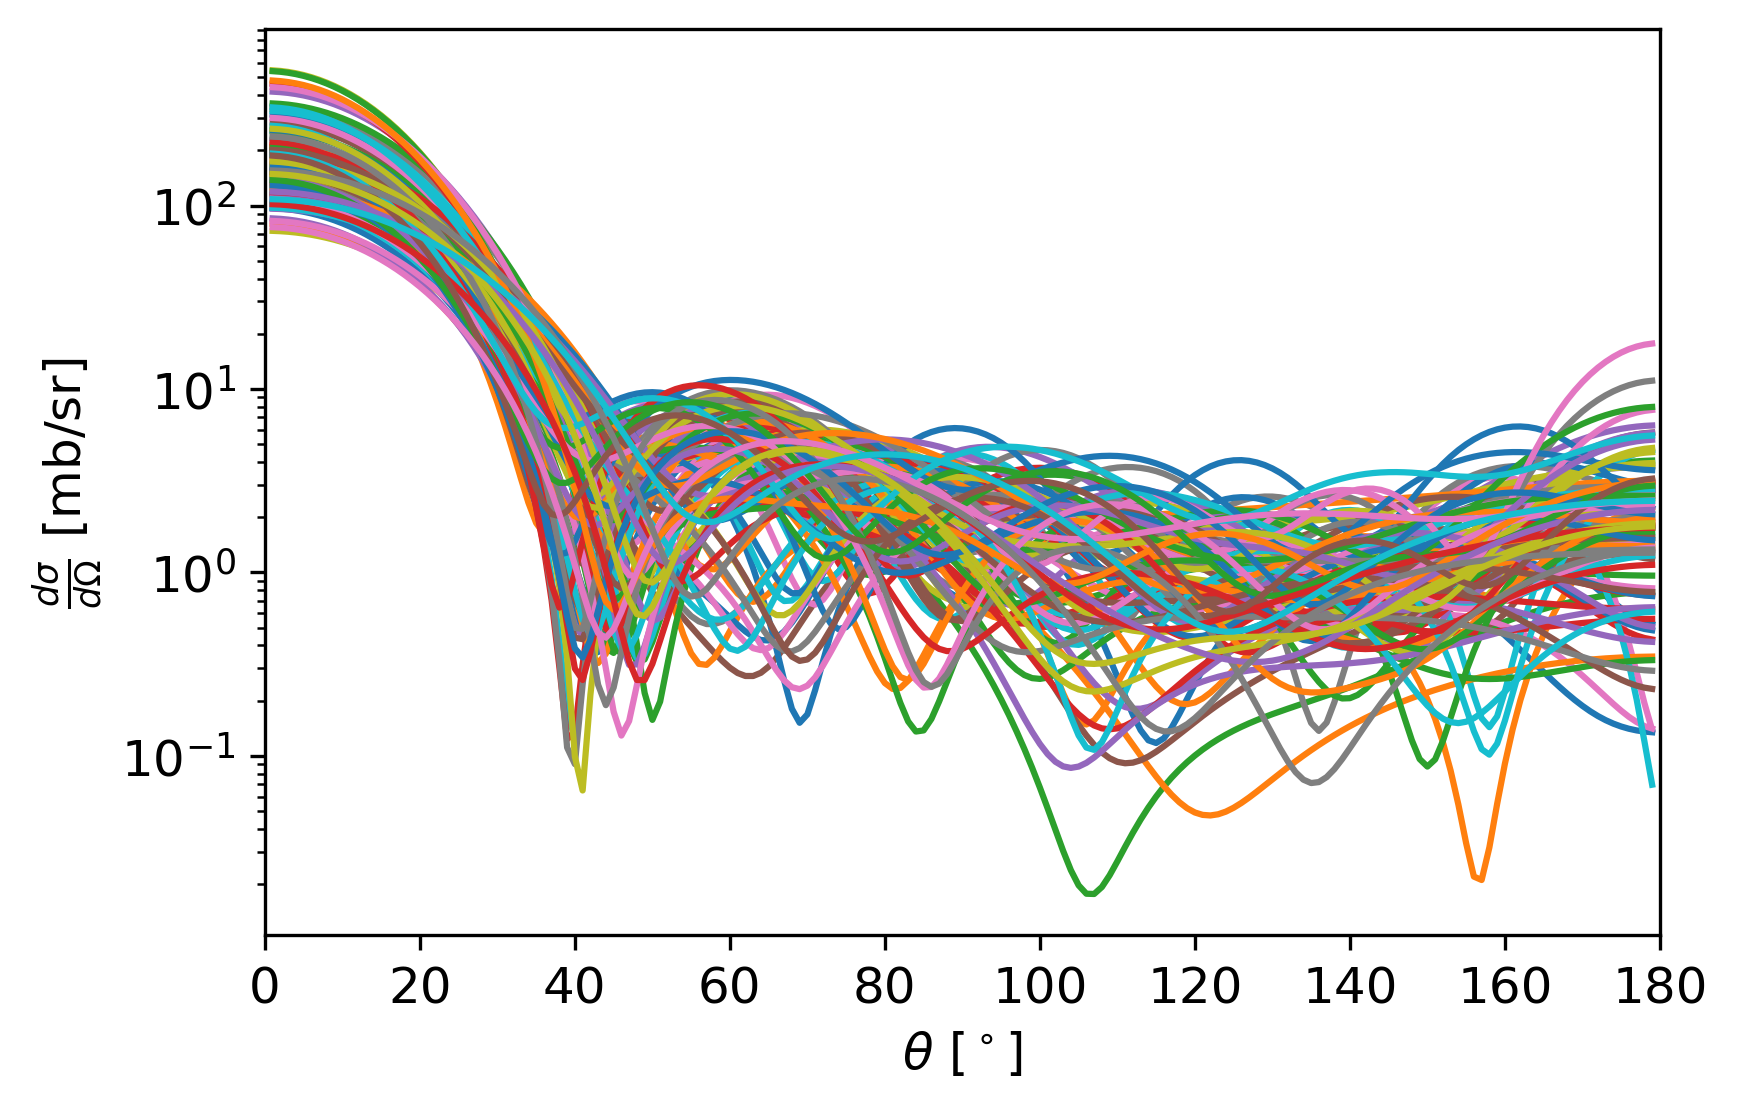

In [15]:
# now let's plot the differential scattering cross section for each of these samples test points!
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")


for i in range(n_test):
    ax.plot(angles, test_CS[i])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

Great, we have our test cross section! Now let's reproduce them with our emulator.

In [16]:
# calculate the exact differential cross section for the 50 test parameters we sampled
test_CS_emu = []
for params in tqdm(test_samples):
    test_CS_emu.append(emulator.emulate_dsdo(params))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 389.60it/s]


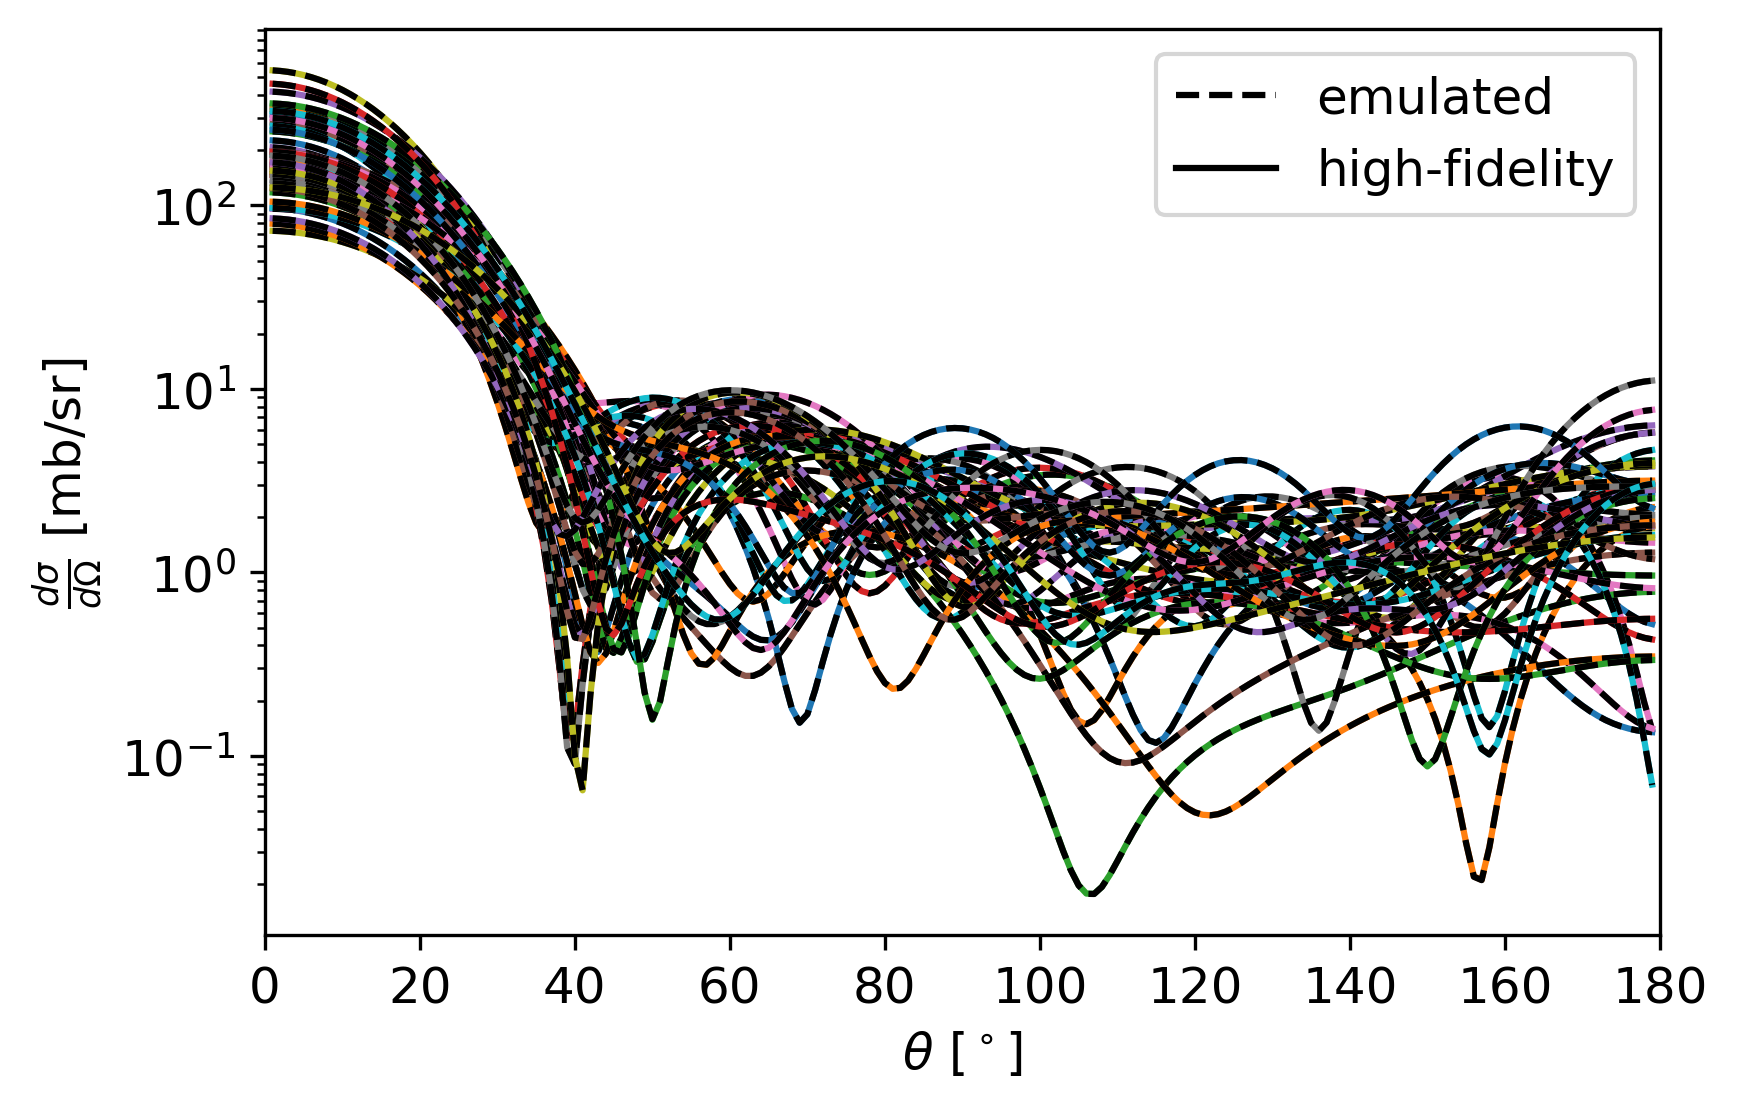

In [17]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

# only plot some of them so the plot isn't too cluttered
for i in range(50):
    p = ax.plot(angles, test_CS[i])
#     ax.plot(angles, test_CS_emu[i], linestyle= "dashed" ,color=p[0].get_color())
    ax.plot(angles, test_CS_emu[i], linestyle= "dashed" ,color='k')

    # ax.plot(angles, test_CS[i])
    # ax.plot(angles, test_CS_emu[i], linestyle= "dashed" )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

This is not bad, but we can do better by optimizing the hyperparameters a bit. Many computational methods have one or more handles to trade off better accuracy at the cost of loss of speed. In the case of the reduced basis emulator we can directly change 1) the size of the reduced basis, and 2) the number of terms in the EIM expansion. Remember, we used 5 reduced basis elements, and 11 EIM terms. 

Let's write a little function that can test more configurations:

In [18]:
trainer_tolerance=-9 #The tolerance used for the high fidelity solver for training the emulator

def emulator_trainer(sae_config: tuple):
    r"""
    build an emulator to specification of sae_config
    Parameters:
        sae_config (size of reduced basis, number of EIM terms)
    """

    (n_basis, n_EIM) = sae_config

    interaction_space_eim = rose.InteractionEIMSpace(
        optical_potential,
        nparams,
        MU,
        energy,
        l_max,
        training_info=train_EIM,
        rho_mesh=rho,
        spin_orbit_potential=spin_orbit_potential,
        explicit_training = True,
        is_complex=True,
        n_basis=n_EIM,
    )


    emulator = rose.ScatteringAmplitudeEmulator.from_train(
        interactions,
        training_samples,
        l_max,
        n_basis=n_basis,
        s_0=s_0,
        s_mesh=rho,
        angles=angles / 180 * np.pi,
        hf_tols=[
            10 ** (trainer_tolerance),
            10 ** (trainer_tolerance),
        ],
    )    
    
    return emulator

Great, now let's choose a few configurations for the emulator and compare them. Our metrics will be:
1. time to generate solution
2. accuracy of solution (relative to the HF solver with a very small tolerance)

For each of the configs we run, we will set up the emulator, and calculate these 2 metrics. First, we will do the offline training for all the emulator configs. This is where most of the computational expense of an emulator comes in; training in the offline stage. Once each partial wave, at each paramater sample point, has it's reduced basis trained, the online stage, where we calculate observables, should be much faster.

In [19]:
# [basis size, number of terms in EIM decomposition]
# Sae_configs = [(3, 3),  (3, 5), (5,5), (7,7) ,(10, 10),(14,14),(20,20)]

# Sae_configs = [(3, 3), (7,7) ,(10, 10),(14,14),(20,20)]

# Sae_configs = [(3, 3), (3,5) , (5,3) , (5,5), (7,7) ,(10, 10),(12,12)]


# Sae_configs = [(3, 3), (3,5) , (5,3) , (5,5), (7,7) ,(10, 10),(12,12)]

# Sae_configs = [(3, 3), (5,5), (7,7) ,(10, 10),(12,12),(20,20)]

Sae_configs = [(7,7) ,(10, 10),(15,15)]


In [20]:

# set up the emulators for each config
Sae_Emulators = {}

for saeconfig in Sae_configs:
    key = f"sae_{saeconfig[0]}_{saeconfig[1]}"
    Sae_Emulators[key] = emulator_trainer(saeconfig)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [01:54<00:00, 10.42s/it]
/home/pablo/.local/lib/python3.10/site-packages/rose/utility.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])
100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [02:00<00:00, 11.00s/it]


We would like to compare the results of our emulartors to HF solvers at a variety of tolerances, to make sure using an emulator is actually worthwhile, as opposed to just cranking down the tolerances on our HF solver. To do that, let's also set up some "dummy" `ScatteringAmplitudeEmulators`; we will just use for their HF solvers:

In [21]:
# log of tolerance
HF_configs=[-2,-3,-4 ,-5] 


In [22]:

# set up the HF solvers for each config
HF_Solvers={}

for HFconfig in HF_configs:
    key = f'HF_{-HFconfig}'
    HF_Solvers[key]=rose.ScatteringAmplitudeEmulator.from_train(
        interactions,
        sample_points(2, bounds), # only 2 training points so training is quick
        l_max,
        n_basis = 2, # only 2 basis elements so trainnig is quick
        s_0=s_0,
        s_mesh=rho,
        angles = angles/180*np.pi,
        hf_tols=[10**(HFconfig),10**(HFconfig)]) # we will only be using the HF solver here

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.96it/s]


We can compare a prediction comming from one of the emulators (5 basis for wave functions, 3 for EIM), one of the HF, and the original highest fidelity solver we employed as follows:

Great, we have trained all of our emulators and set up our HF solvers. Now let's write a function that calculates the metrics we've defined; accuracy and speed, for each sampled test parameter. We will then invoke it to get the metrics for our set of emulator configurations, and our HF solver configurations. We call this kind of analysis Computational Accuracy vs. Time (CAT) analysis, and the resulting plots, CAT plots.

In [23]:
def CAT_Data_Maker(CS_calculator, test_parameters, test_data):
    # Both the predictions and the test_data are evaluated over all angles
    max_error_list=[]
    prediction_list = []
    times_list = []
    for i in range(len(test_parameters)):
        st = time.time()
        predicted = CS_calculator(test_parameters[i])
        et = time.time()
        prediction_list.append(predicted)
        times_list.append(et - st)

    residual_list = []
    residual_list_median = []
    
    
    #Calculating residuals over all the angles:
    for i in range(len(test_parameters)):
        residual_list.append(
            np.fabs((prediction_list[i] - test_data[i])) / (test_data[i])
        )
        residual_list_median.append(np.median(residual_list[i]))
        max_error_list.append(np.max(residual_list[i]))
#     #Calculating residuals over the subset of angles:
#     for i in range(len(test_parameters)):
#         residual_list.append(
#             np.fabs((prediction_list[i][anglesX] - test_data[i][anglesX])) / (test_data[i][anglesX])
#         )
#         residual_list_median.append(np.median(residual_list[i]))
        
        
        
        
        
    return [times_list, residual_list_median, residual_list, prediction_list,max_error_list]

In [61]:
# get times and residuals for emulation with each config
CAT_Emulator_Data = {}

for sae in tqdm(Sae_Emulators):
    CAT_Data = CAT_Data_Maker(Sae_Emulators[sae].emulate_dsdo, test_samples, test_CS)

    CAT_Emulator_Data[sae] = {
        "times": CAT_Data[0],
        "median_residuals": CAT_Data[1],
        "residuals_list": CAT_Data[2],
        "full_predictions": CAT_Data[3],
        "max_residuals": CAT_Data[4],
    }

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.66it/s]


In [69]:
# Sae_Emulators['sae_30_30'] = emulator_trainer((30,30))

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [01:46<00:00,  9.68s/it]
/home/pablo/.local/lib/python3.10/site-packages/rose/utility.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


In [71]:
# sae='sae_30_30'
# CAT_Data = CAT_Data_Maker(Sae_Emulators[sae].emulate_dsdo, test_samples, test_CS)

# CAT_Emulator_Data[sae] = {
#     "times": CAT_Data[0],
#     "median_residuals": CAT_Data[1],
#     "residuals_list": CAT_Data[2],
#     "full_predictions": CAT_Data[3],
#     "max_residuals": CAT_Data[4],
# }

See how quick it was to emulate the cross sections? That's what we mean by a fast online stage!

In [25]:
# get times and residuals for the HF solver withb each config
CAT_HF_Data = {}

for HF in tqdm(HF_Solvers):
    CAT_Data = CAT_Data_Maker(HF_Solvers[HF].exact_dsdo, test_samples, test_CS)

    CAT_HF_Data[HF] = {
        "times": CAT_Data[0],
        "median_residuals": CAT_Data[1],
        "residuals_list": CAT_Data[2],
        "full_predictions": CAT_Data[3],
        "max_residuals": CAT_Data[4],
    }

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.90s/it]


In [59]:
# with open('CAT_HF_Data_Dec18.pkl', 'wb') as file:
#     pickle.dump(CAT_HF_Data, file)


In [60]:
# with open('CAT_Emulator_Data_Dec18.pkl', 'wb') as file:
#     pickle.dump(CAT_Emulator_Data, file)


In [23]:
with open('CAT_Emulator_Data_Dec10.pkl', 'rb') as file:
    CAT_Emulator_Data = pickle.load(file)

In [24]:
with open('CAT_HF_Data_Dec10.pkl', 'rb') as file:
    CAT_HF_Data = pickle.load(file)

Adding one extra emulator trained across energies

In [26]:
energy_min=10
energy_max=30

In [27]:
energies=np.arange(energy_min,energy_max,(energy_max-energy_min)/len(train_EIM))

In [28]:
energies_wf=np.arange(energy_min,energy_max,(energy_max-energy_min)/len(training_samples))

In [29]:
train_EIM_energy=np.column_stack((energies, train_EIM))

In [30]:
train_WF_energy=np.column_stack((energies_wf, training_samples))

In [31]:
energies_test=np.full(len(test_samples),energy)

In [32]:
test_samples_energy=np.column_stack((energies_test, test_samples))

In [33]:
nparams_energized=11

Energy_reference=20

def optical_potential_energized(r, theta):
    EE,Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    E_eff=EE/Energy_reference
    k_eff=np.sqrt(E_eff)
    return ((-1j * Wv - Vv) * wood_saxon(r/k_eff, Rv, av) + (4j * ad * Wd) * wood_saxon_prime(
        r/k_eff, Rd, ad
    ))*(1/E_eff)
    
def spin_orbit_potential_energized(r, theta, ldots):
    EE,Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    E_eff=EE/Energy_reference
    k_eff=np.sqrt(E_eff)
    return ((Vso) * mso**2 * ldots * wood_saxon_prime(r/k_eff, Rso, aso) / (r/k_eff))*(1/E_eff)



In [34]:
interaction_space_eim_energized = rose.InteractionEIMSpace(
    optical_potential_energized,
    nparams_energized,
    MU,
    Energy_reference,
    l_max,
    training_info=train_EIM_energy,
    rho_mesh=rho,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential_energized,
    explicit_training = True,
    n_basis=15
)





In [35]:
emulator_energized = rose.ScatteringAmplitudeEmulator.from_train(
    interaction_space_eim_energized,
    train_WF_energy,
    l_max,
    s_mesh=rho,
    s_0=s_0,
    n_basis=15,
    angles=angles / 180 * np.pi,
    hf_tols=[
        10 ** (-9),
        10 ** (-9),
    ],  # these are the relative and absolute tolerances for the HF Runge-Kutta solver
)



100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [02:06<00:00, 11.49s/it]


In [42]:
def CS_emulator_energized(params):
    return emulator_energized.emulate_dsdo(params)*(Energy_reference/energy)

In [63]:
CAT_Data = CAT_Data_Maker(CS_emulator_energized, test_samples_energy, test_CS)

CAT_Emulator_Data['sae_15_15_Energized'] = {
    "times": CAT_Data[0],
    "median_residuals": CAT_Data[1],
    "residuals_list": CAT_Data[2],
    "full_predictions": CAT_Data[3],
    "max_residuals": CAT_Data[4],
}

In [63]:
# with open('CAT_Emulator_Data_Dec10.pkl', 'wb') as file:
#     pickle.dump(CAT_Emulator_Data, file)


Comparatively, calculating cross sections with the HF solver takes forever...

## Generate the CAT Plot

Now that we have the runtimes and residuals for each emulator and HF configuration, let's throw it all onto a nice CAT plot. A lot of the code bellow is done to create aesthetically pleasing CAT plots, you could always just plot the mean computation time vs the mean error for each emulation configuration in a simple way.

In [55]:
# Sae_configs_plotting=[(7,7) ,(10, 10),(15,15)]

Sae_configs_plotting=[(7,7),(10,10),(15,15)]

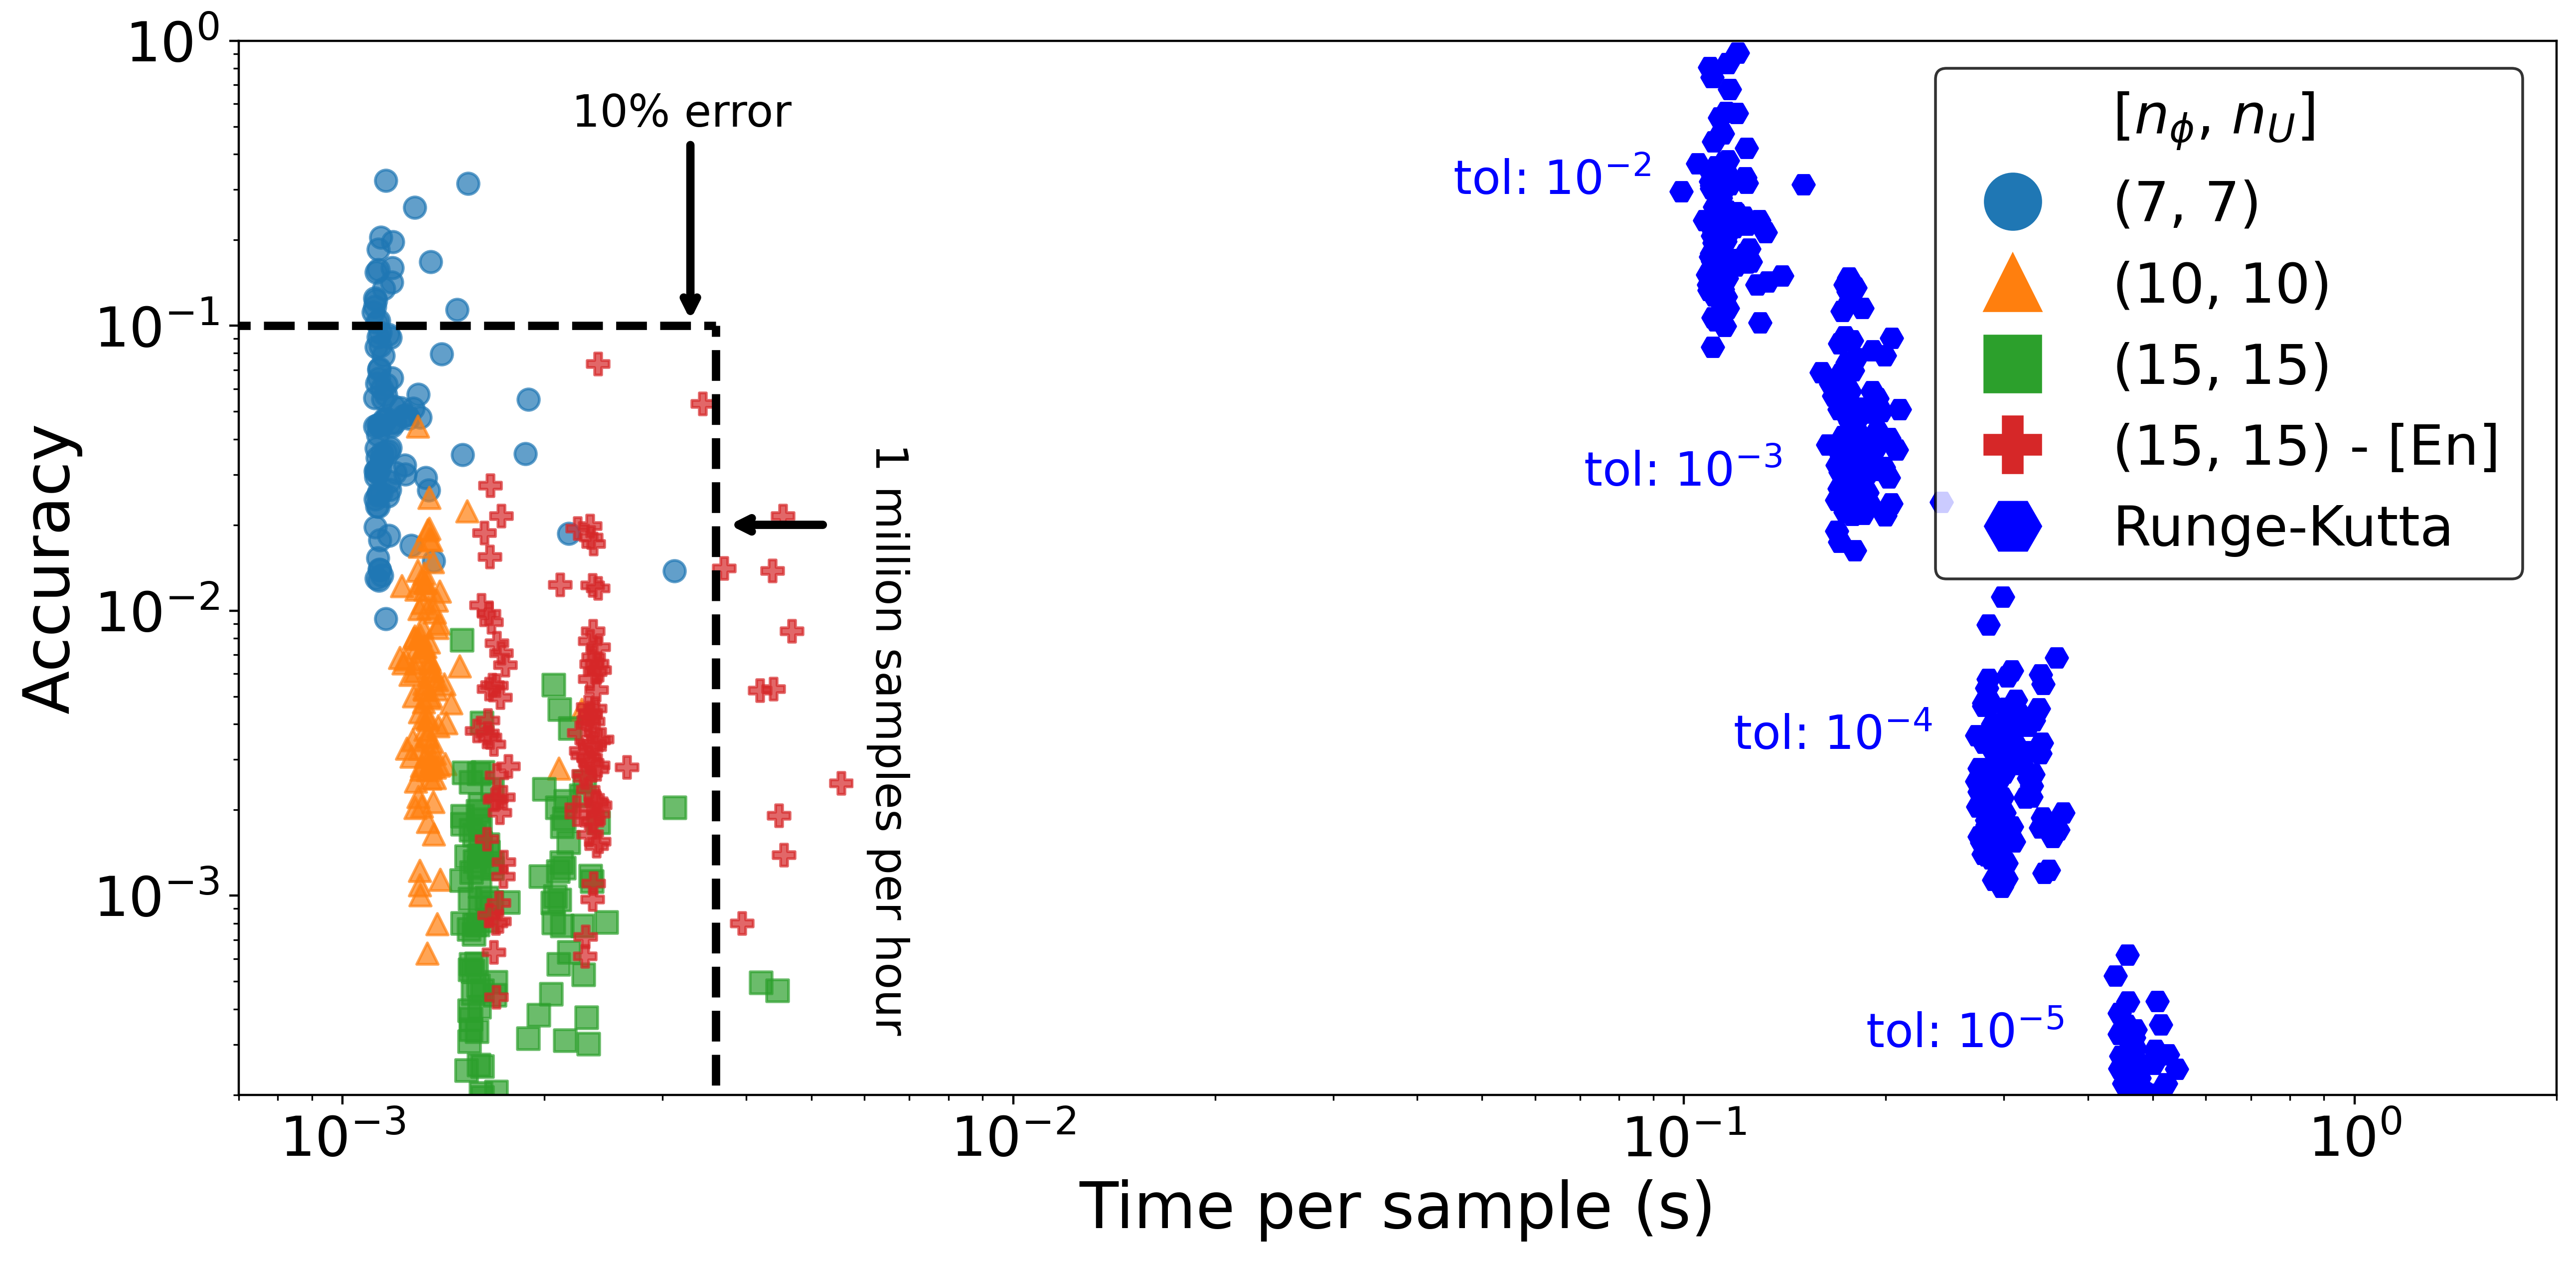

In [64]:
#Some colors that Pablo likes:
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
] 






markers = [
    "o",  # Circle
    "^",  # Triangle up
    "s",  # Square
    "P",  # Plus (filled)
    "*",  # Star
    "X",  # X (filled)
    "D",  # Diamond
    "H",  # Hexagon
]

fig, ax = plt.subplots(figsize=(15, 7), dpi=400)

custom_lines = []

custom_lines.append(
    Line2D(
        [],
        [],
        color="w",
        marker="X",
        linestyle="None",
        markersize=20,
        label="[$n_\phi$, $n_U$]",
    )
)
i = 0
for sae in Sae_Emulators:
# for sae in list([
# #     'sae_3_3',


# #  'sae_7_7',
# #  'sae_10_10',
#  'sae_15_15',
#   'sae_20_20' ,
#     'sae_30_30' 
#                 ]):
#     data_sae = [
#         np.array(CAT_Emulator_Data[sae]["times"]),
#         np.array( [    np.median(CAT_Emulator_Data[sae]["residuals_list"][ii]) for ii in range(len(CAT_Emulator_Data[sae]["residuals_list"]))   ]  ),
#     ]
    
    data_sae = [
        np.array(CAT_Emulator_Data[sae]["times"]),
        np.array( [    (CAT_Emulator_Data[sae]["max_residuals"][ii]) for ii in range(len(CAT_Emulator_Data[sae]["max_residuals"]))   ]  ),
    ]
    
    
    data_sae = np.array(data_sae)

  
    ax.scatter(data_sae[0], data_sae[1], s=60, color=colors[i],alpha=0.7,marker=markers[i])

    custom_lines.append(
        Line2D(
            [],
            [],
            color=colors[i],
#             marker="o",
            marker=markers[i],
            linestyle="None",
            markersize=20,
            label=str(Sae_configs_plotting[i]),
#             label=sae,
        )
    )

    i = i + 1

#Energy version    
# sae='sae_10_10_Energized'
sae='sae_15_15_Energized'
data_sae = [
    np.array(CAT_Emulator_Data[sae]["times"]),
    np.array( [    np.median(CAT_Emulator_Data[sae]["max_residuals"][ii]) for ii in range(len(CAT_Emulator_Data[sae]["max_residuals"]))   ]  ),
]

data_sae = np.array(data_sae)


ax.scatter(data_sae[0], data_sae[1], s=60, color=colors[i],alpha=0.7,marker=markers[i])

custom_lines.append(
    Line2D(
        [],
        [],
        color=colors[i],
#             marker="o",
        marker=markers[i],
        linestyle="None",
        markersize=20,
#         label=str('(10, 10) - [En]'),
        label=str('(15, 15) - [En]'),
    )
)

i = i + 1

    
    
    
# selected_list_HF=[2,3,4,5]    

coordinates_fudge=[1,0.5,1,1.4,1]

i = 0
for HF in HF_Solvers:
    
# for p in range(len(selected_list_HF)):
    
#     ij=selected_list_HF[p]
#     HF=list(CAT_HF_Data.keys())[ij]

    data_hf = [
        np.array(CAT_HF_Data[HF]["times"]),
        np.array( [   (CAT_HF_Data[HF]["max_residuals"][ii]) for ii in range(len(CAT_HF_Data[HF]["max_residuals"]))   ]  ),
    ]
    data_hf = np.array(data_hf)
   
    ax.scatter(data_hf[0], data_hf[1], s=60, color="b",marker=markers[-1])
   

    ax.text(np.mean(data_hf[0])*0.55, np.mean(data_hf[1])*1.1*coordinates_fudge[i],
#             "RK Tol.("+"{:.2e}".format(10**(HF_configs[ij]))+")",
#             "("+ str(HF_configs[ij])+")",
           r"tol: $10^{" + str(HF_configs[i]) + "}$",
            color='b', fontsize=17, ha='center')
   
#     ax.text(np.mean(data_hf[0])*1.05, np.mean(data_hf[1])*3.5*coordinates_fudge[i],
# #             "RK Tol.("+"{:.2e}".format(10**(HF_configs[ij]))+")",
# #             "("+ str(HF_configs[ij])+")",
#            r"tol: $10^{" + str(HF_configs[i]) + "}$",
#             color='b', fontsize=16, ha='center')


    i = i + 1
    



custom_lines.append(
    Line2D(
        [], [], color="b", marker=markers[-1], linestyle="None", markersize=20, label="Runge-Kutta"
    )
)


# custom_lines.append(
#     Line2D(
#         [], [], color="grey",alpha=0.6, marker=markers[2], linestyle="None", markersize=20, label="FRESCO"
#     )
# )



ax.legend(handles=custom_lines, fontsize=20, frameon=True, edgecolor="black",loc='upper left', bbox_to_anchor=(0.72, 1))


ax.text(0.0032, 0.5, '10% error', color='k', fontsize=16, ha='center')

ax.text(0.0065, 0.00035, '1 million samples per hour', color='k', fontsize=16, ha='center',rotation=-90 ,
        bbox={'facecolor': 'white', 'edgecolor': 'white'},)

ax.plot([10 ** (-4), 0.0036], [0.1, 0.1], color="k", linewidth=3, linestyle="dashed")
ax.plot([0.0036, 0.0036], [10 ** (-9), 0.1], color="k", linewidth=3, linestyle="dashed")

arrow_start = (0.0033, 0.45)  # X and Y coordinates of the arrow start point
arrow_end = (0.0033, 0.1)    # X and Y coordinates of the arrow end point


# ax.fill_between([0.03, 0.035], 0.000001, 50, color='gray', alpha=0.5, label='Vertical Band')




# Add an arrow annotation to the plot
ax.annotate('', xy=arrow_end, xytext=arrow_start,
            arrowprops=dict(arrowstyle='->', color='black',linewidth=3))

arrow_start = (0.0053, 0.02)  # X and Y coordinates of the arrow start point
arrow_end = (0.0037, 0.02)    # X and Y coordinates of the arrow end point

# Add an arrow annotation to the plot
ax.annotate('', xy=arrow_end, xytext=arrow_start,
            arrowprops=dict(arrowstyle='->', color='black',linewidth=3))


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time per sample (s)", fontsize=23)
ax.set_ylabel(
    r"Accuracy", fontsize=23
)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

plt.xlim(7 * 10 ** (-4), 2 * 10 ** (0))
plt.ylim(0.2*10 ** (-3), 10 ** (0))

plt.show()

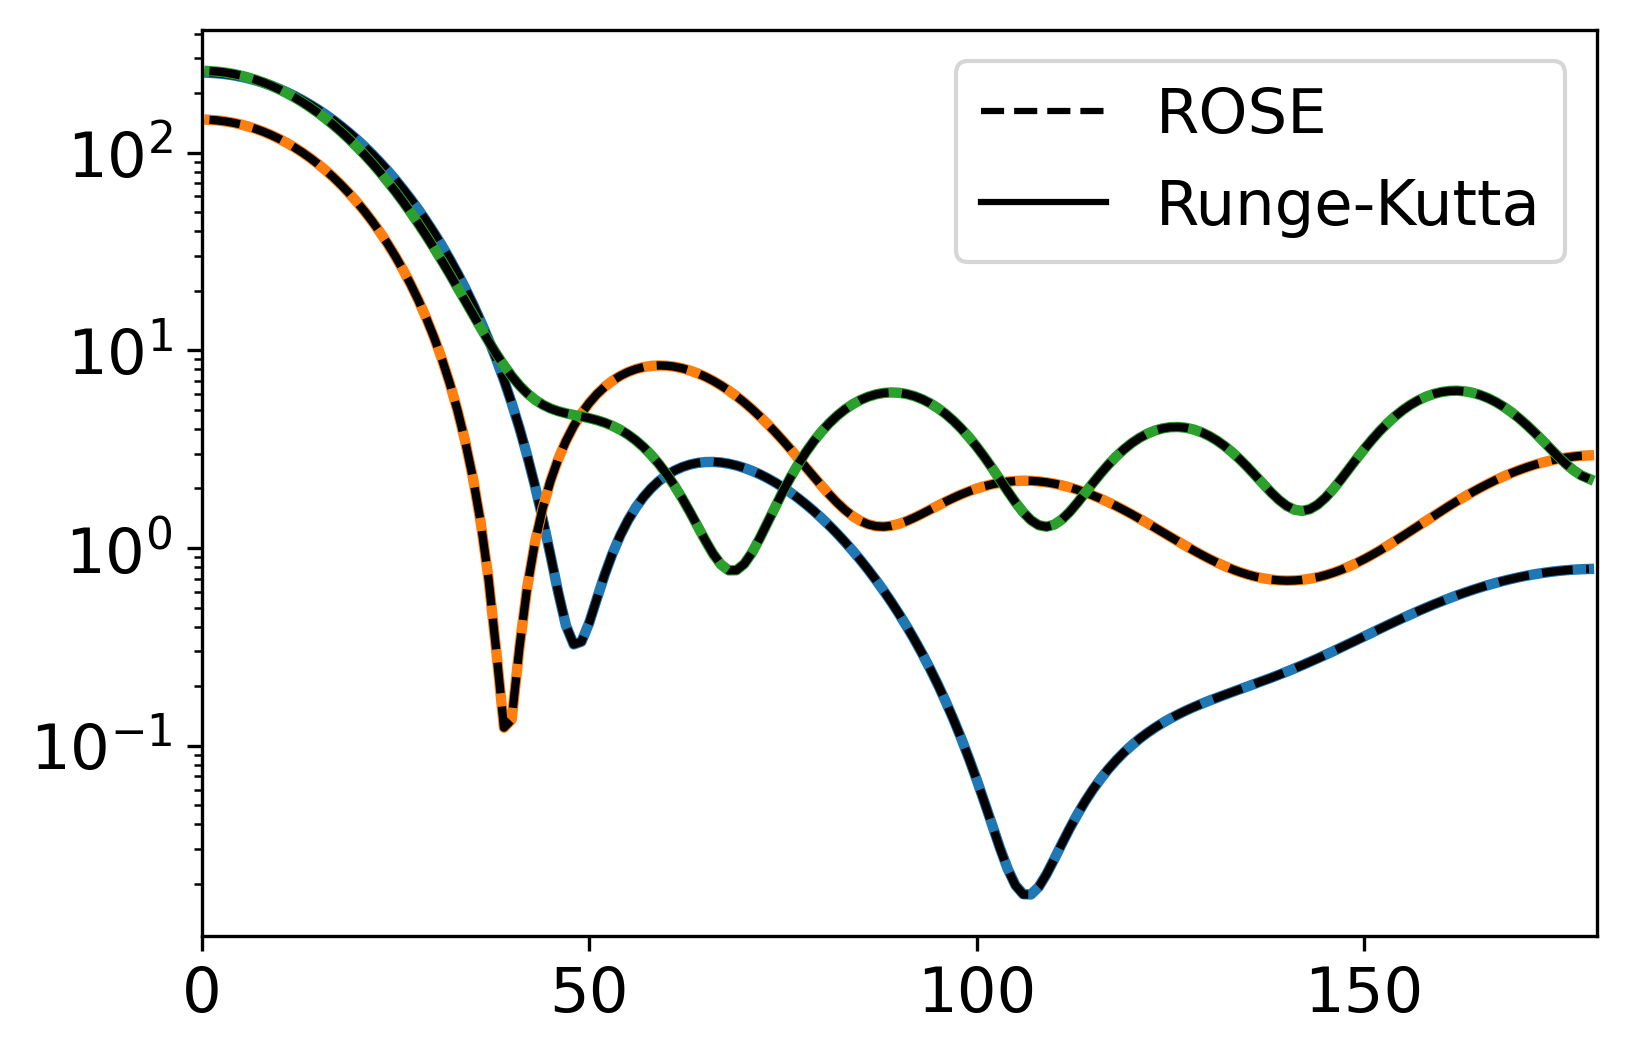

In [67]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

# only plot some of them so the plot isn't too cluttered
listvals=[12,13,40]

# for i in range(15):
for i in listvals:
    p = ax.plot(angles, test_CS[i],linewidth=2.5)
    ax.plot(angles, CAT_Emulator_Data['sae_15_15']["full_predictions"][i], linestyle= "dashed" ,color='k',linewidth=2)

    # ax.plot(angles, test_CS[i])
    # ax.plot(angles, test_CS_emu[i], linestyle= "dashed" )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
ax.legend(legend_styles, ["ROSE", "Runge-Kutta"],fontsize=15)
ax.set_yscale("log")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.xlim([0, 180])
# plt.xlabel(r"$\theta$ [$^\circ$]")
# plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]",fontsize=20,labelpad=-75)
plt.show()

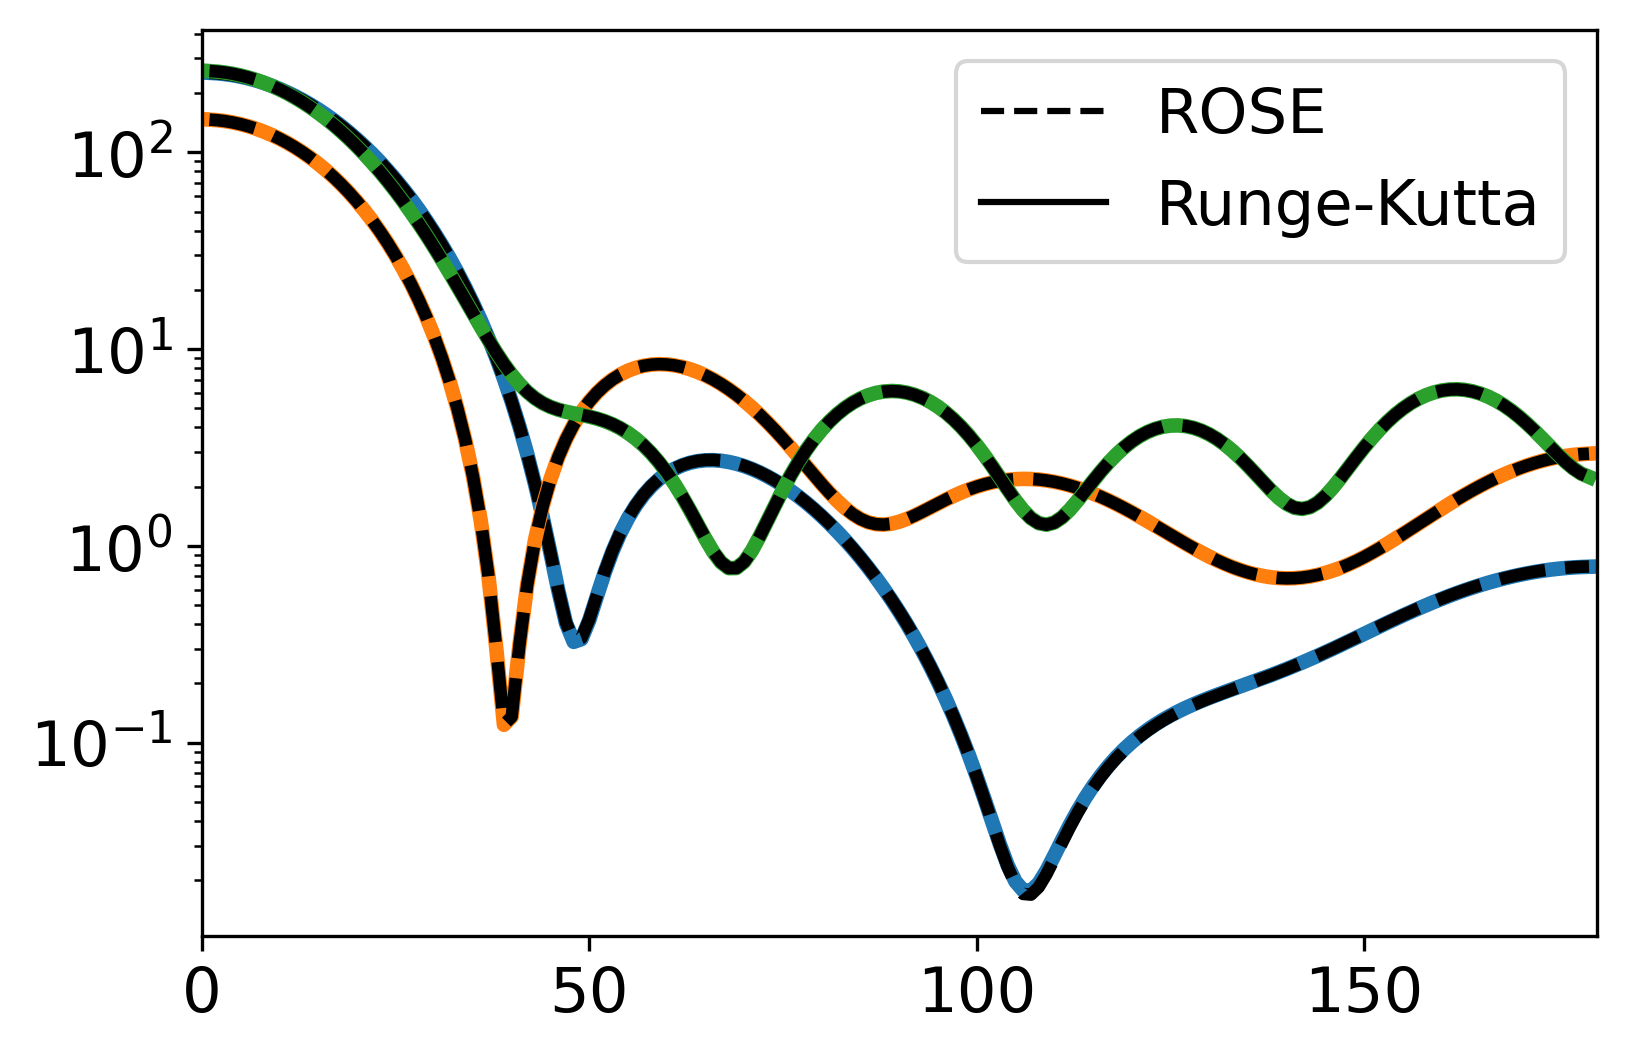

In [69]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

# only plot some of them so the plot isn't too cluttered
listvals=[12,13,40]

# for i in range(15):
for i in listvals:
    p = ax.plot(angles, test_CS[i],linewidth=3.5)
    ax.plot(angles, CAT_Emulator_Data['sae_10_10']["full_predictions"][i], linestyle= "dashed" ,color='k',linewidth=3)

    # ax.plot(angles, test_CS[i])
    # ax.plot(angles, test_CS_emu[i], linestyle= "dashed" )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
ax.legend(legend_styles, ["ROSE", "Runge-Kutta"],fontsize=15)
ax.set_yscale("log")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.xlim([0, 180])
# plt.xlabel(r"$\theta$ [$^\circ$]")
# plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]",fontsize=20,labelpad=-75)
plt.show()

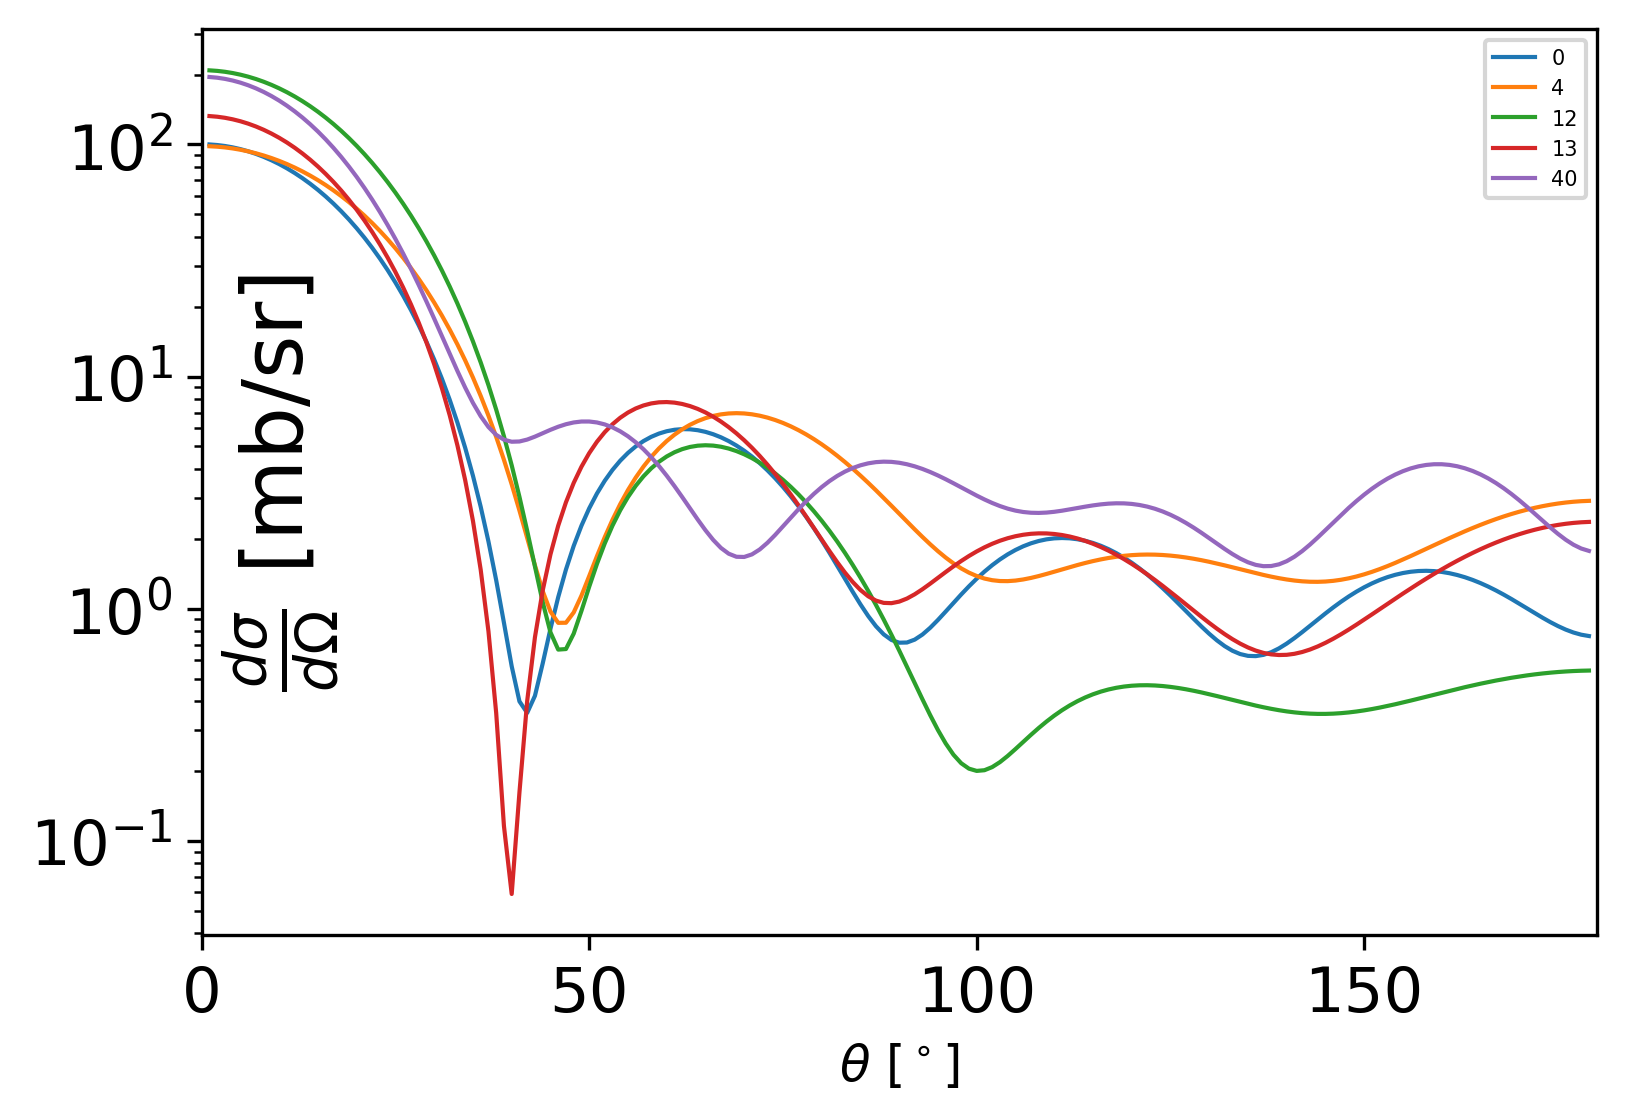

In [47]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

listvals=[0,4,12,13,40]

# for i in range(15):
for i in listvals:
    p = ax.plot(angles, test_CS[i],linewidth=1,label=f'{i}')
#     ax.plot(angles, CAT_Emulator_Data['sae_10_10']["full_predictions"][i], linestyle= "dashed" ,color='k',linewidth=2)

    # ax.plot(angles, test_CS[i])
    # ax.plot(angles, test_CS_emu[i], linestyle= "dashed" )


ax.legend(fontsize=5)
ax.set_yscale("log")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]",fontsize=20,labelpad=-75)
plt.show()

In [99]:
CAT_Emulator_Data['sae_10_10'].keys()

dict_keys(['times', 'median_residuals', 'residuals_list', 'full_predictions', 'max_residuals'])